In [1]:
import os
import pandas as pd
import re
import numpy as np

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

directory = os.getcwd()

# List to hold the DataFrames
level_dfs = {}

pattern = r'\((PEL|SFE|JFE)[^\)]*\)'
NUM_LEVELS = 3

def clean_and_fill_column(col, num_levels):
    # Remove 'Unnamed' and empty elements
    cleaned_col = [elem.replace('\n', '').strip() for elem in col if 'Unnamed' not in elem and elem]
    
    # Fill missing levels with an empty string to maintain the correct length
    while len(cleaned_col) < num_levels:
        cleaned_col.append('')
    
    return tuple(cleaned_col)

# Loop through each file in the directory
for file in os.listdir(directory):
    if file.endswith(".xls"):
        # Full file path
        file_path = os.path.join(directory, file)

        level_match = re.search(pattern, file)
        level = level_match.group(0)[1:-1]
        
        df = pd.read_excel(file_path, sheet_name='Summary', header=[0, 1, 2])
        df.columns = pd.MultiIndex.from_tuples([clean_and_fill_column(col, NUM_LEVELS) for col in df.columns.values])
        first_nan_index = df[df[('Class',)].isna()].index[0]
        df = df.iloc[:first_nan_index]
        level_dfs[level] = df


/tmp/ipykernel_298485/2964849748.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_nan_index = df[df[('Class',)].isna()].index[0]
/tmp/ipykernel_298485/2964849748.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_nan_index = df[df[('Class',)].isna()].index[0]
/tmp/ipykernel_298485/2964849748.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_nan_index = df[df[('Class',)].isna()].index[0]
/tmp/ipykernel_298485/2964849748.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_nan_index = df[df[('Class',)].isna()].index[0]
/tmp/ipykernel_298485/2964849748.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_nan_index = df[df[('Class',)].isna()].index[0]
/tmp/ipykernel_298485/2964849748.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  first_nan_index = df[df[('Class',)].isna()].index[0

In [2]:
print(level_dfs.keys())

dict_keys(['JFE 1', 'JFE 2', 'JFE 4', 'JFE 5', 'JFE 6', 'PEL 1', 'PEL 2', 'SFE 1', 'SFE 2', 'SFE 3', 'SFE High School'])


In [3]:
ID_COLUMNS = ['SN', 'Class', 'Student(s)', 'Semester 1 Result (%)', 'Semester 2 Result (%)', 'Overall Result (%)']
LEVELS = 3

def split_into_terms(df):
    top_level = df.columns.get_level_values(0).unique()
    
    term_dfs = {}

    for term in top_level:
        if term in ID_COLUMNS:
            continue
        # Select columns that belong to this top-level group along with 'SN', 'Student(s)', and 'Class'
        columns_to_include = [(col,) + ('',) * (LEVELS - 1) for col in ID_COLUMNS] + [col for col in df.columns if col[0] == term]
        
        # Create a new DataFrame for this level
        term_df = df.loc[:, columns_to_include]

        new_columns = []
        for col in term_df.columns:
            if col[1] in ['Total Marks', 'Total Percent']:
                new_columns.append((col[1].replace('Total', 'Term').replace('Percent', '%'), '', ''))
            else:
                new_columns.append(col)  # Keep the original tuple
        term_df.columns = pd.MultiIndex.from_tuples(new_columns)
        
        # Store the DataFrame in the dictionary
        term_dfs[term] = term_df

    # Display the resulting DataFrames
    # for term, term_df in term_dfs.items():
        # print(f"DataFrame for {term}:\n")
        # display(term_df.head())

    return term_dfs

In [4]:
def extract_component_details(expanded_term_df):
    # Define regex pattern to extract sequence, name, max score, and percentage
    pattern = r'(?:(?P<ComponentSequence>\d+)\.\s)?(?P<Component>.+?)\s\((?P<MarkAllocation>\d+\.\d+)\sMarks\s\|\s(?P<PercentAllocation>\d+\.\d+)%'
    
    # Extract the components using the pattern
    extracted = expanded_term_df['Component'].str.extract(pattern)
    
    # Convert MarkAllocation and PercentageAllocation to numeric types
    extracted['MarkAllocation'] = pd.to_numeric(extracted['MarkAllocation'], errors='coerce')
    extracted['PercentAllocation'] = pd.to_numeric(extracted['PercentAllocation'], errors='coerce')
    extracted['Component'] = extracted['Component'].fillna(expanded_term_df['Component']) # handle normal Component Values
    
    # Replace the old Component column with the new one
    expanded_term_df = expanded_term_df.drop(columns=['Component']).join(extracted)
    expanded_term_df['Component Performance'] = np.where(
        (expanded_term_df['MarkAllocation'] != 0) & (expanded_term_df['Component Marks'] != 0),
        expanded_term_df['Component Marks'] / expanded_term_df['MarkAllocation'],
        np.nan  # Assign NaN where division by zero would occur
    )

    # display(expanded_term_df)

    return expanded_term_df

def expand_term_table(df):
    id_vars = ID_COLUMNS + ['Term Marks', 'Term %']

    df_melted = pd.melt(df, id_vars=id_vars, var_name=['Assessment', 'Component', 'Metric'], value_name='Score')

    df_pivoted = df_melted.pivot_table(index=ID_COLUMNS + ['Assessment', 'Component', 'Term Marks', 'Term %'], 
                                    columns='Metric', values='Score', aggfunc='first').reset_index()
    
    df_pivoted['Term'] = df_pivoted['Assessment'].str.extract(r'Term (\d+)')
    df_pivoted.columns.name = None
    df_pivoted = df_pivoted.drop(columns=['SN'])
    df_pivoted = df_pivoted.rename(columns={'%': 'Component %', 'Mark': 'Component Marks'})
    df_pivoted['Component Marks'] = pd.to_numeric(df_pivoted['Component Marks'], errors='coerce')
    df_pivoted = extract_component_details(df_pivoted)
    return df_pivoted

    print(df_pivoted.columns)
    display(df_pivoted)

In [5]:
FINAL_ORDER = ['Class', 'Student(s)', 'Term', 'Assessment', 'Component', 'ComponentSequence', 'Component Marks', 'MarkAllocation', 'Component Performance', 'Component %', 'PercentAllocation', 'Term Marks', 'Term %', 'Semester 1 Result (%)', 'Semester 2 Result (%)', 'Overall Result (%)']

all_level_dfs = {}
    
for level, level_df in level_dfs.items():
    term_dfs = split_into_terms(level_df)

    expanded_term_dfs = []
    
    for term_df in term_dfs.values():
        expanded_term_df = expand_term_table(term_df)
        expanded_term_dfs.append(expanded_term_df)
    
    concatenated_terms_df = pd.concat(expanded_term_dfs, axis=0)
    concatenated_terms_df = concatenated_terms_df[FINAL_ORDER]

    all_level_dfs[level] = concatenated_terms_df.reset_index()

In [6]:
# for level, level_df in all_level_dfs.items():
    # print(f"DataFrame for {level}:\n")
    # display(level_df)

### Data Visualization

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import math

In [8]:
# print(all_level_dfs.keys())

In [9]:
def compare_components_by_levels(levels, byMetric='Component Marks', wrap_width=20):
    n_levels = len(levels)
    n_cols = 2
    n_rows = math.ceil(n_levels / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    axs = axs.flatten() 

    for i, level in enumerate(levels):
        try:
            level_df = all_level_dfs[level].copy()
        except KeyError:
            print(f"{level} is not found! Level options are: {list(all_level_dfs.keys())}")
            continue

        # Convert the byMetric column to numeric
        level_df[byMetric] = pd.to_numeric(level_df[byMetric], errors='coerce')
        level_df = level_df.dropna(subset=[byMetric])

        sns.boxplot(x='Component', y=byMetric, hue='Term', data=level_df, ax=axs[i])

        ax = axs[i]
        labels = [textwrap.fill(label.get_text(), wrap_width) for label in ax.get_xticklabels()]
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_title(f'{byMetric} Distribution for {level}')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

## Comparing Component Performances across All Levels

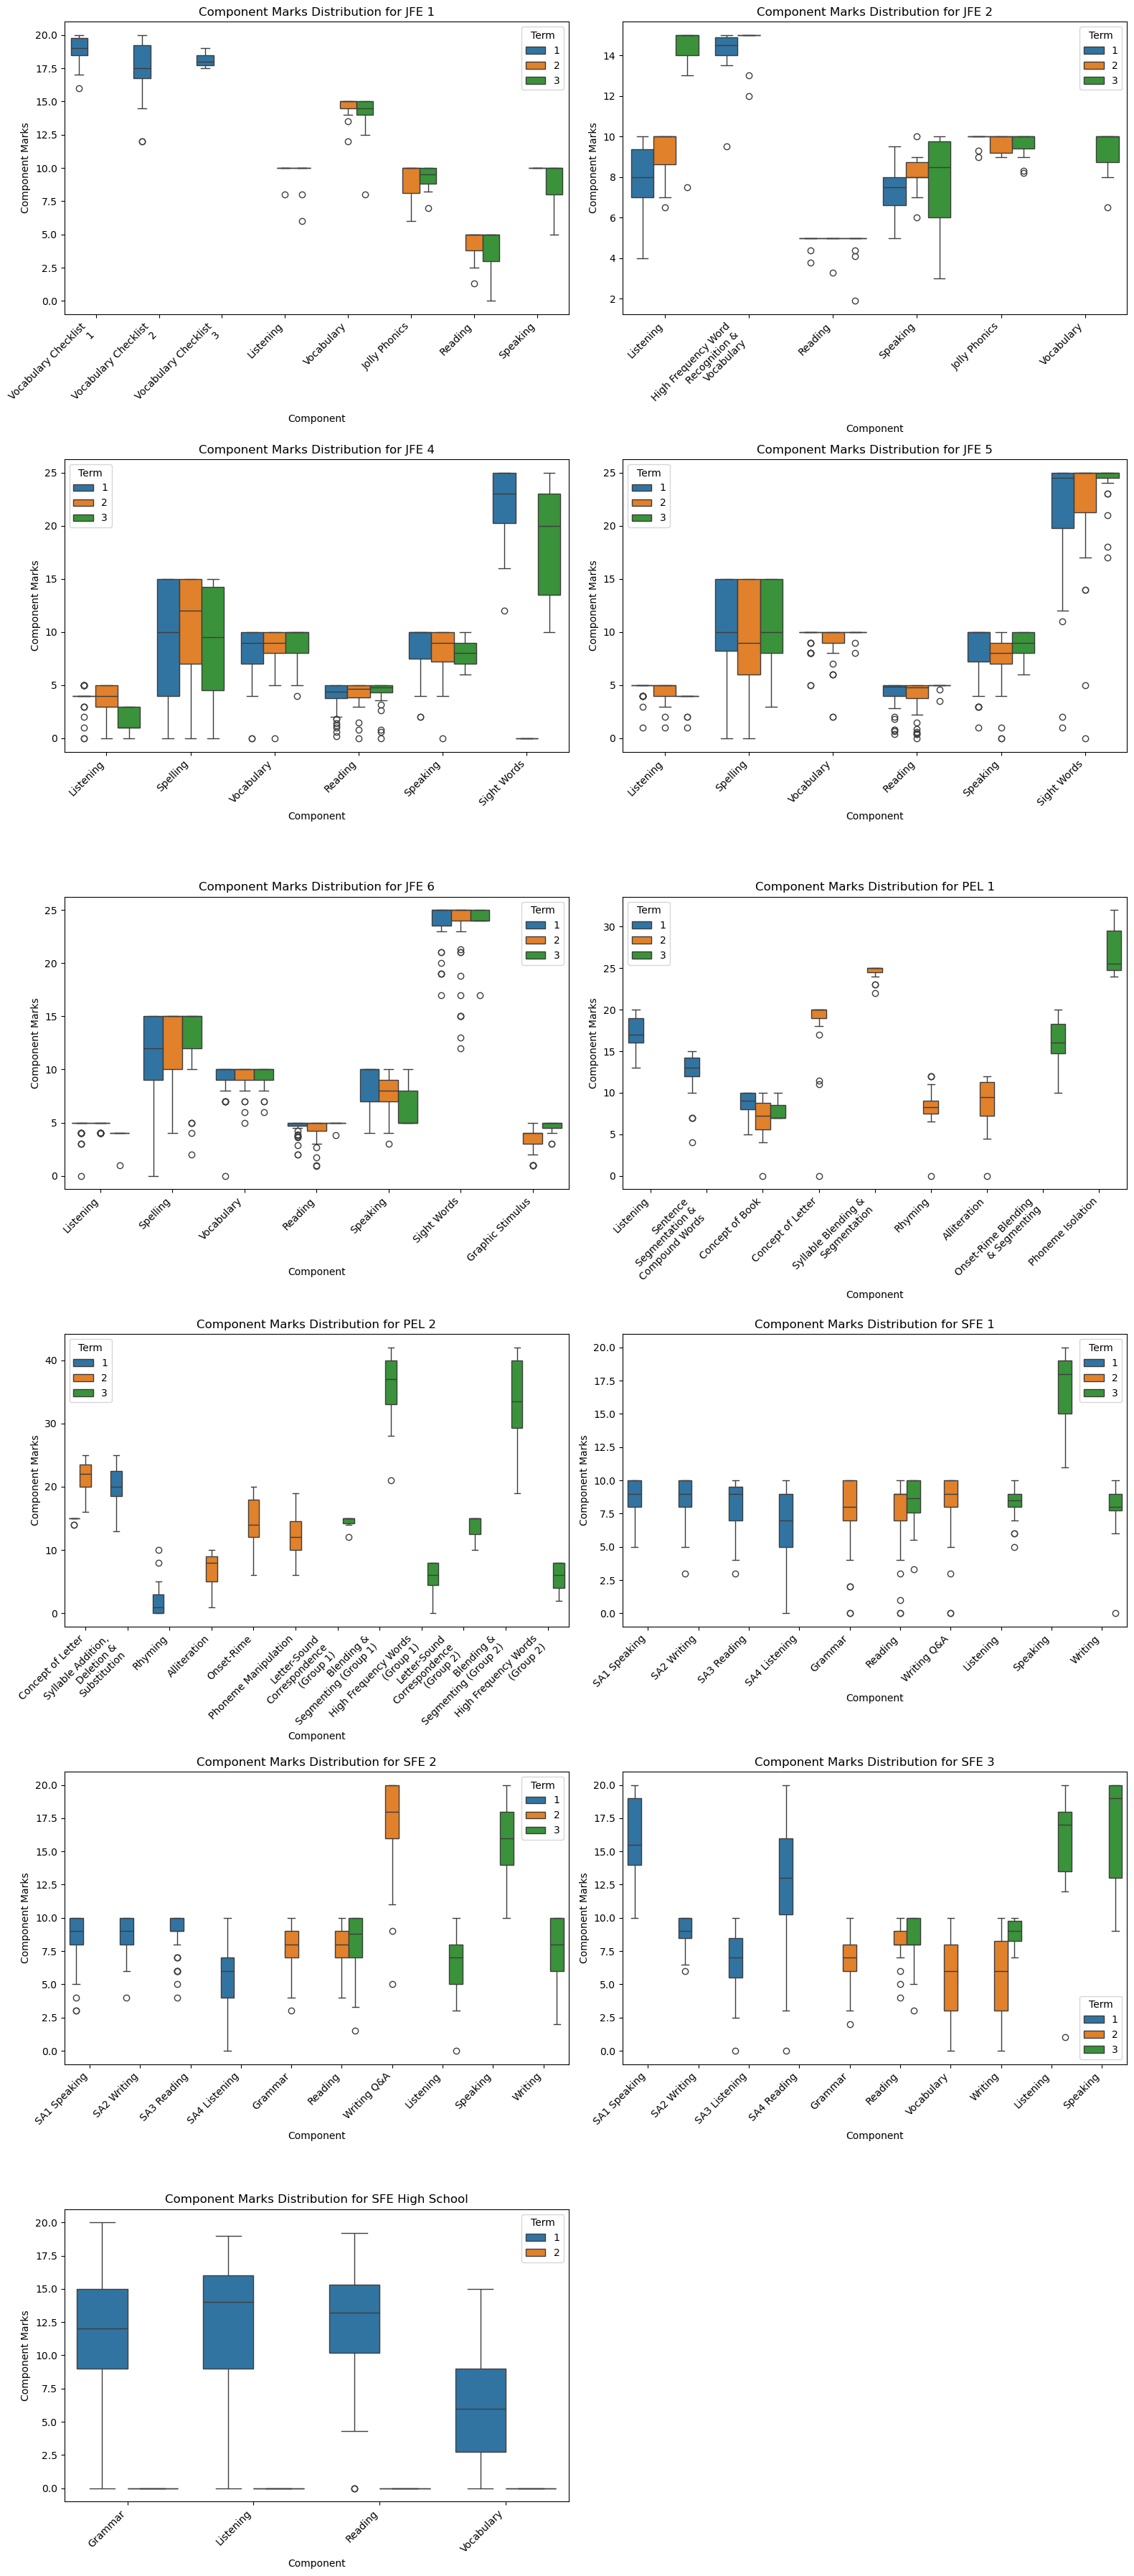

In [10]:
compare_components_by_levels(all_level_dfs.keys())

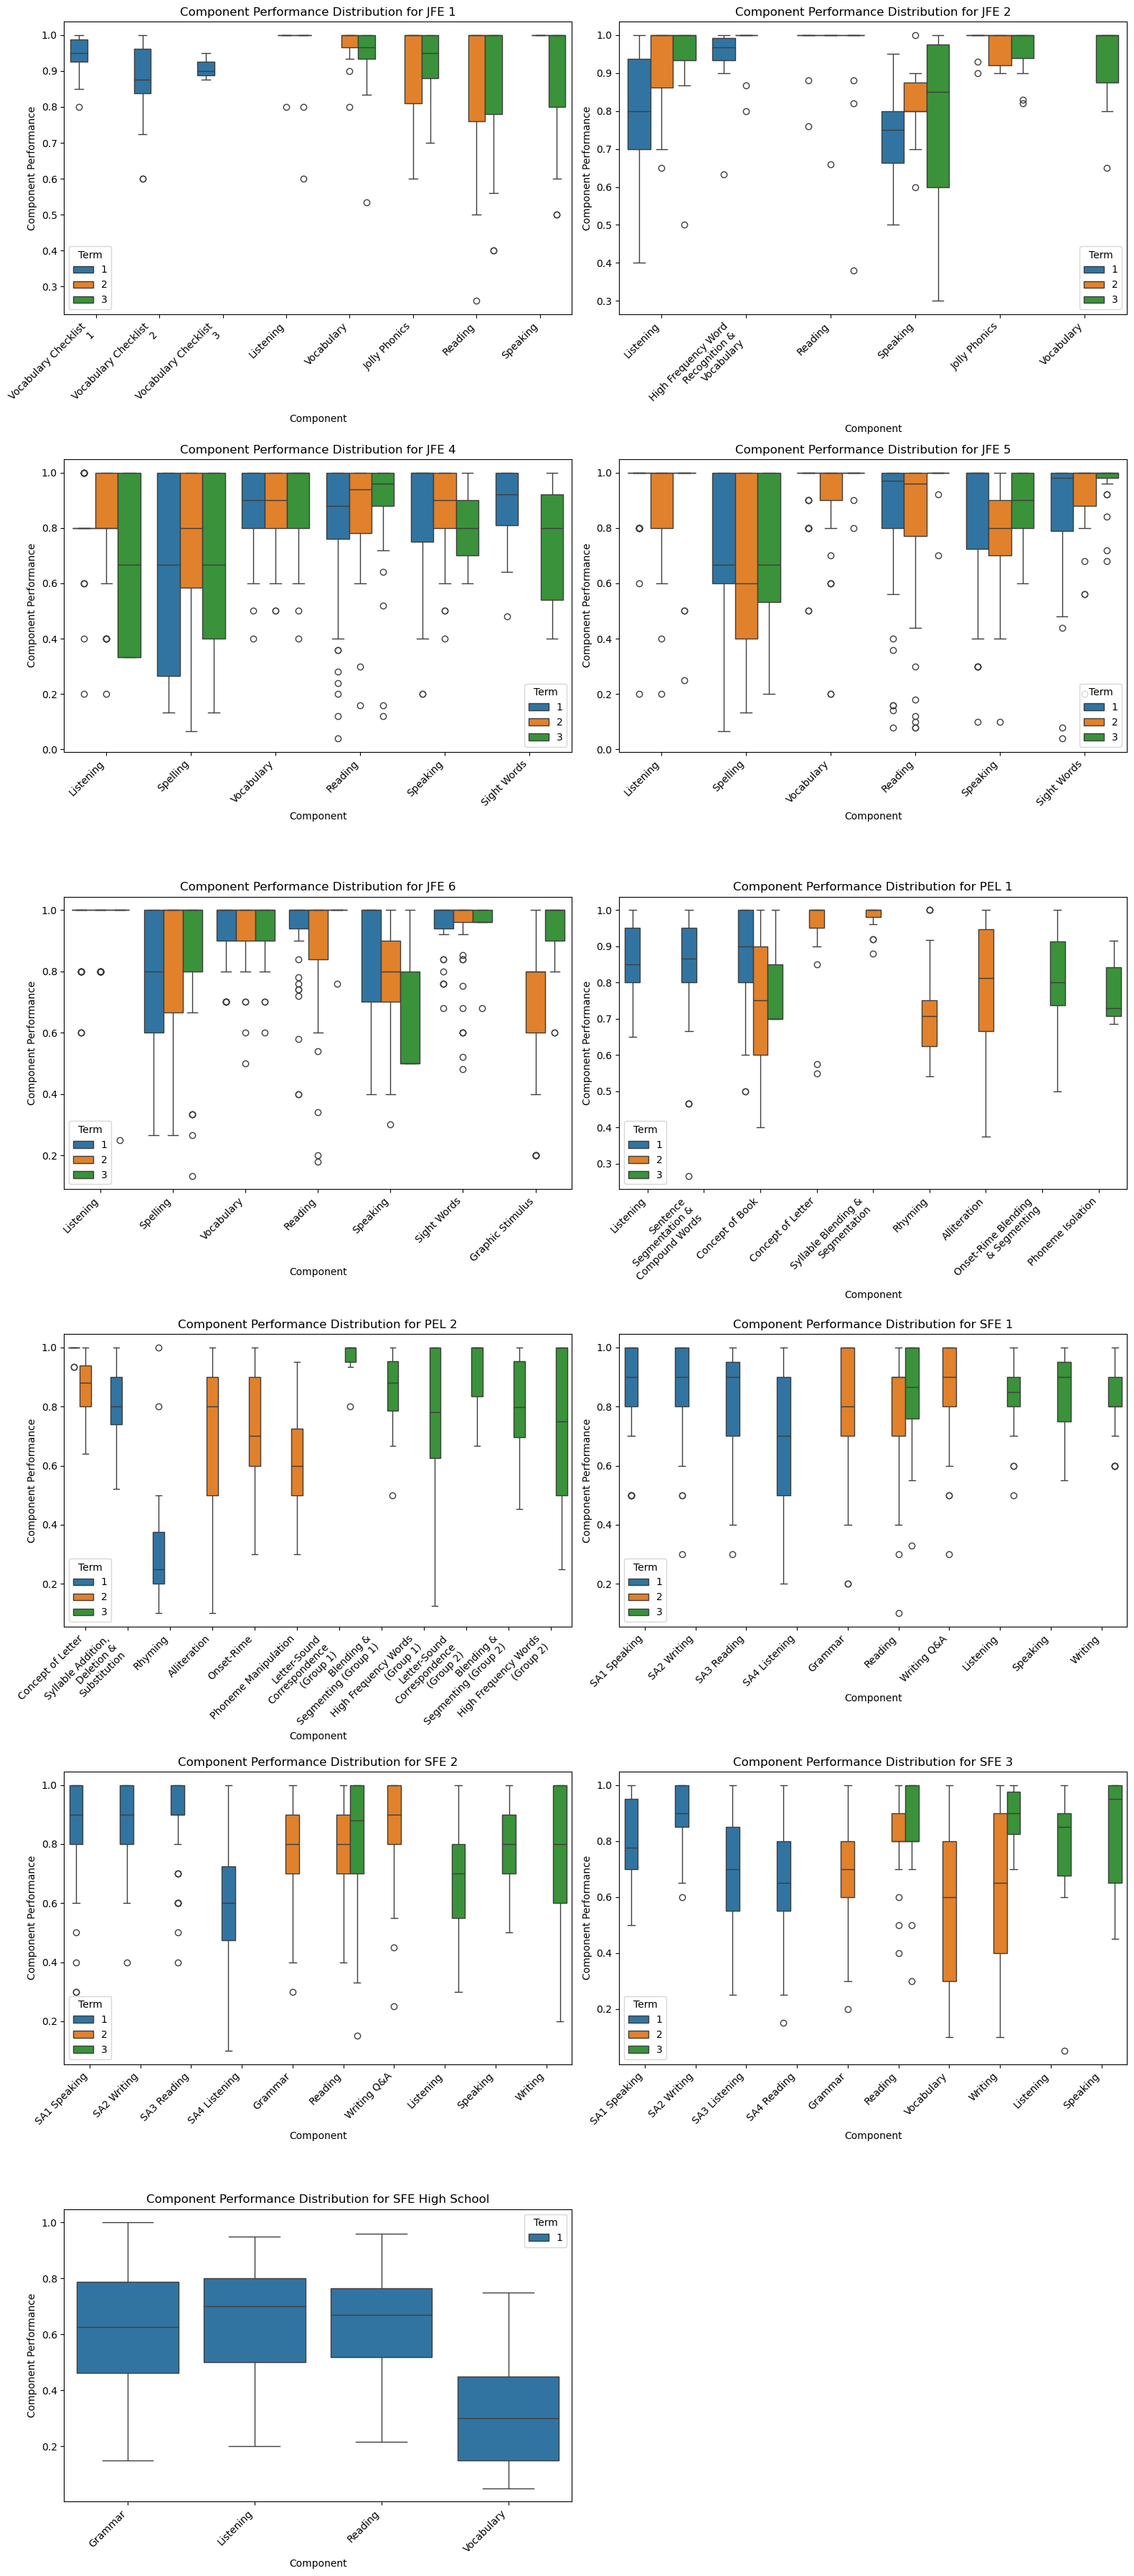

In [11]:
compare_components_by_levels(all_level_dfs.keys(), byMetric='Component Performance')

In [12]:
def heatmap_for_level(level, byMetric='Component Marks', group_components=True):
    try:
        level_df = all_level_dfs[level].copy()
    except KeyError:
        print(f"{level} is not found! Level options are: {list(all_level_dfs.keys())}")
        return

    # Ensure that the byMetric column is numeric
    level_df[byMetric] = pd.to_numeric(level_df[byMetric], errors='coerce')
    level_df = level_df.dropna(subset=[byMetric])

    pivot_column = 'Component'
    if not group_components:
        # Create a new column to combine Component and Term
        level_df['Component_Term'] = level_df['Component'] + ' (Term ' + level_df['Term'].astype(str) + ')'
        pivot_column = 'Component_Term'

    # Pivot the DataFrame
    pivot_df = level_df.pivot_table(index='Student(s)', columns=pivot_column, values=byMetric, aggfunc='mean')

    # Compute the correlation matrix
    corr = pivot_df.corr()

    # Plot a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap of {byMetric} for {level}')
    plt.show()


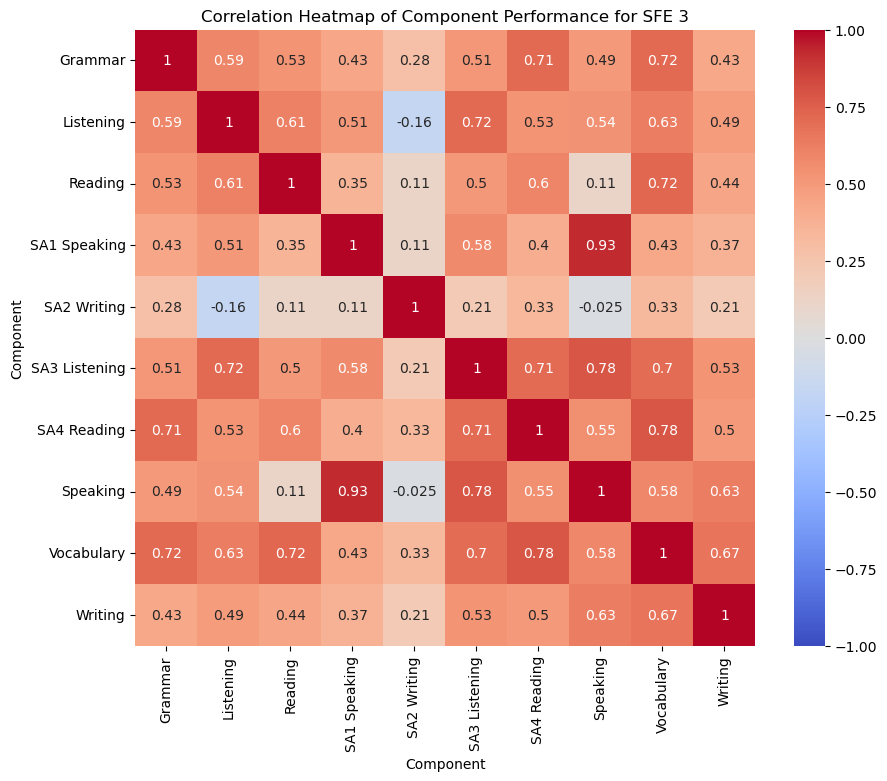

In [13]:
heatmap_for_level('SFE 3', byMetric='Component Performance')